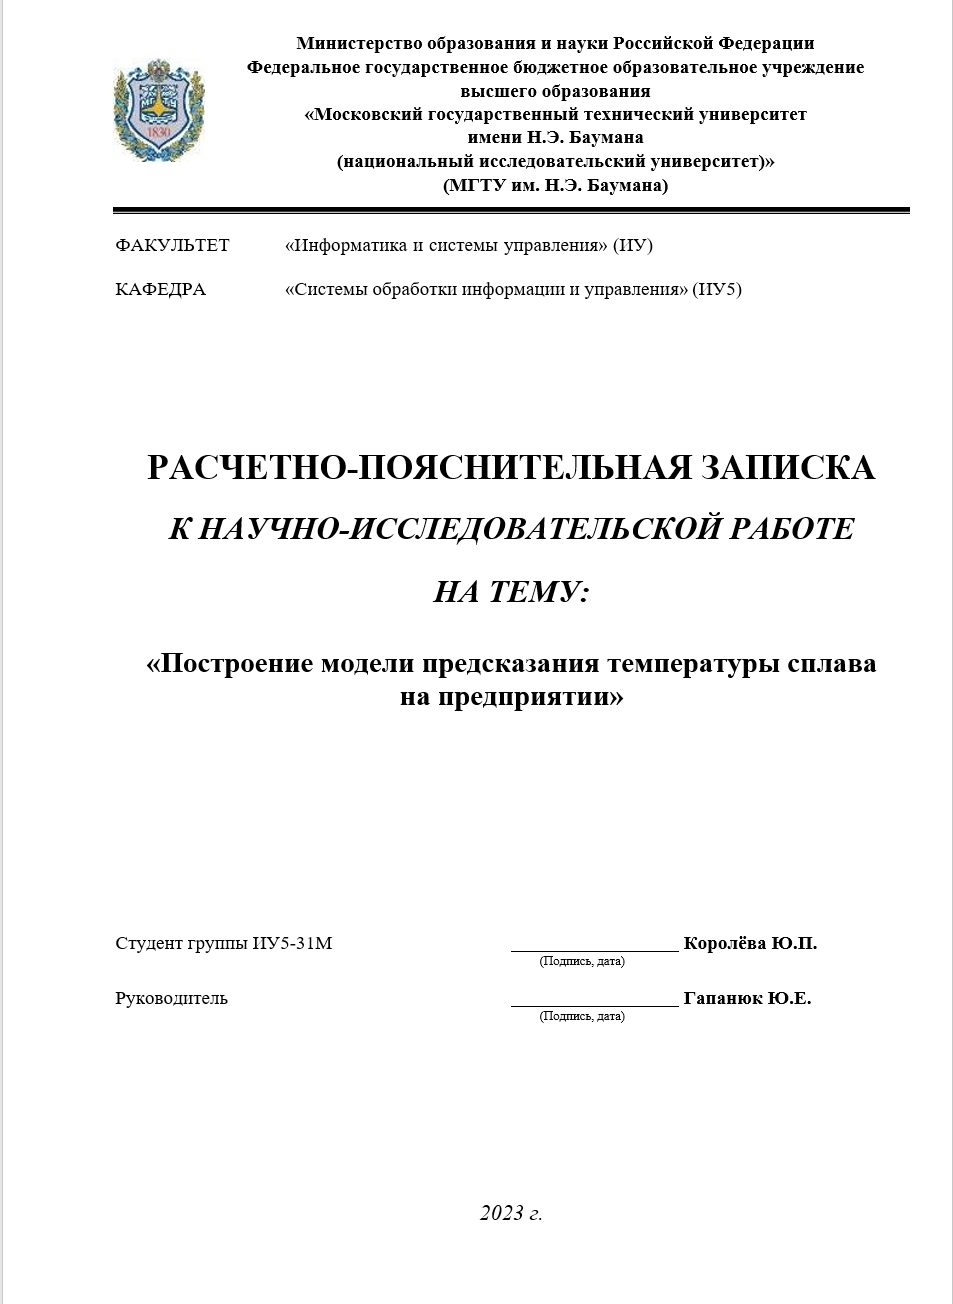

# Предсказание температуры стали

# Описание проекта:

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали.

**Цель.** Построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

**Данные состоят из файлов, полученных из разных источников:**
-	data_arc_new.csv — данные об электродах;
-	data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
-	data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
-	data_gas_new.csv — данные о продувке сплава газом;
-	data_temp_new.csv — результаты измерения температуры;
-	data_wire_new.csv — данные о проволочных материалах (объём);
-	data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Данные**
* data_arc_new.csv
* data_bulk_new.csv
* data_bulk_time_new.csv
* data_gas_new.csv
* data_temp_new.csv
* data_wire_new.csv
* data_wire_time_new.csv


# План работы над финальным проектом

1.	Изучить технологический процесс обработки стали.
2.	Метрика качества модели MAE. Решаем задачу регрессии.
3.	Загрузить данные из файлов.
4.	Провести исследование и предобработку данных:
    * Изучить данные: посмотреть типы данных, обозначения, пропуски, дубликаты, статистики, аномалии, выбросы, выделить целевой признак и существенные, удалить несущественные, оценить признаки с точки зрения масштабирования.
    *	Обработать пропуски, используя подходящие способы: удаление, заполнение. Обосновать способ обработки пропусков.
    *	Проверить данные на аномалии, выбросы. Обработать. Аномалии удалить. Выбросы удалить только из обучающей выборки.
    *	Построить графики и диаграммы.
    *   Объединить таблицы по ключу key.
    *	Посмотреть корреляцию признаков.
    *	Итоговый вывод по каждому этапу.
6.	Разделить данные на обучающую и тестовую выборки (3:1), randome_state=280823.
7.	Выбрать две модели для обучения. Подобрать наилучшие параметры на кроссвалидации. Обучить модели на тренировочной выборке.
8.	Выбрать наилучшую модель по .best_score.
9.	Проверить выбранную модель на тестовых данных.
10.	Оценить адекватность, сравнив с константной моделью.
11. Пояснения по выполняемым пунктам и промежуточные выводы по каждому этапу.
12.	Написать отчет по выполненной работе.


# Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from catboost import Pool, CatBoostRegressor, cv
from sklearn.dummy import DummyRegressor

In [ ]:
data_arc_new = pd.read_csv("/datasets/data_arc_new.csv")
data_bulk_new = pd.read_csv("/datasets/data_bulk_new.csv")
data_bulk_time_new = pd.read_csv("/datasets/data_bulk_time_new.csv")
data_gas_new = pd.read_csv("/datasets/data_gas_new.csv")
data_temp_new = pd.read_csv("/datasets/data_temp_new.csv")
data_wire_new = pd.read_csv("/datasets/data_wire_new.csv")
data_wire_time_new = pd.read_csv("/datasets/data_wire_time_new.csv")

**Данные об электродах**

In [ ]:
data_arc_new.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Таблица содержит несколько замеров для одной партии. Перед объединением в единую таблицу, значения в таблице data_arc_new стоит агрегировать по мощностям по средним значениям. Можно сначала добавить в таблицу длительность нагревания. Возможно это позводит выделить дополнительные признаки.

В объединенную таблицу пойдут данные содержание key, активную и реактивную мощности по каждому ключу.

In [ ]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [ ]:
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропусков нет.

In [ ]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Видим минимальное значение по реактивной мощности - отрицательное. Посмотрим на диаграмме размаха. Хотя и так видно.

In [1]:
plt.figure(figsize=(10, 7))
plt.title('Диаграмма размаха по значениям Активная/Реактивная мощности')
data_arc_new[["Активная мощность", "Реактивная мощность"]].boxplot();

NameError: ignored

В значениях "Реактивная мощность" наблюдается отрицательное значение. Эту аномалию стоит удалить.

Данные о подаче сыпучих материалов (объём) - различные примеси

In [ ]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [ ]:
data_bulk_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

В данных много пропусков. В таблице определены примеси для каждой партии, поэтому пропуски вполне логичны. Значит эта примесь не использовалась в партии. Поэтому пропуски заполним нулями.

**Данные о подаче сыпучих материалов (время) - различные примеси**

In [ ]:
data_bulk_time_new.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


In [ ]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
data_bulk_time_new.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Пропуски в таблицах data_bulk_time_new и data_bulk_new совпадают, это позволяет сделать вывод о корректности данных. Данные о времени введения примесей для обучения и тестирования не важны, поэтому не будем включать данные из таблицы  data_bulk_time_new в выборку.

**Данные о продувке сплава газом**

In [ ]:
data_gas_new.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


In [ ]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


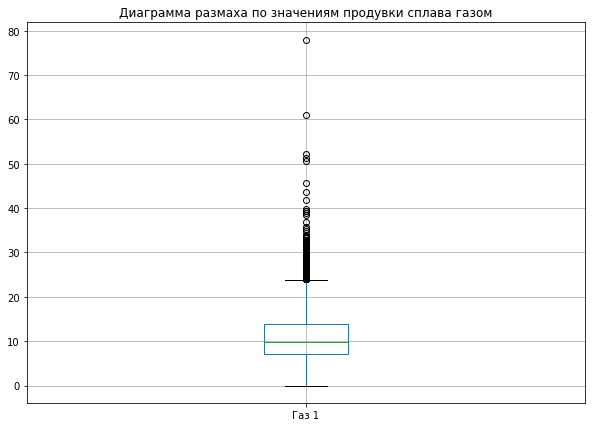

In [ ]:
plt.figure(figsize=(10, 7))
plt.title('Диаграмма размаха по значениям продувки сплава газом')
data_gas_new[['Газ 1']].boxplot();

In [ ]:
data_gas_new.isna().sum()

key      0
Газ 1    0
dtype: int64

**Результаты измерения температуры**

In [ ]:
data_temp_new.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Для каждой партии несколько измерений температур. Сформируем новую таблицу из даннной, оставив две темтературы - начальную и конечную. Начальная температура будет являтся признаком, конечная - таргетом (целевым признаком).

In [ ]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [ ]:
data_temp_new.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

Есть пропуски значений температуры.

In [ ]:
data_temp_new['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Есть записи, содержащие только одно время для партии, это не подходит для описанного технологического процесса, их удалим.

In [ ]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


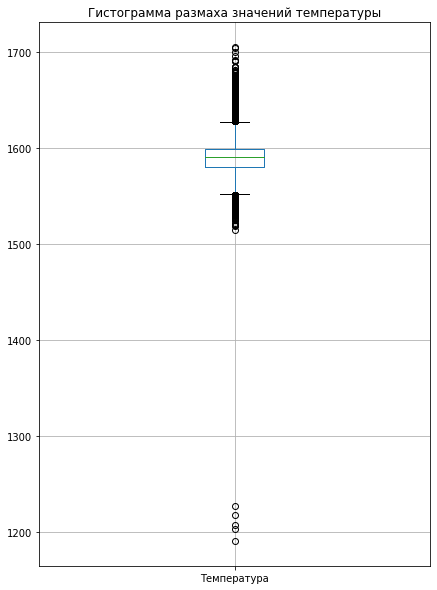

In [ ]:
plt.figure(figsize=(7,10))
plt.title("Гистограмма размаха значений температуры")
data_temp_new[['Температура']].boxplot();

Есть низкие значения температуры, которые не удовлетворяют условию технологиечского процесса. Температуру плавления ниже 1500 удалим. Температура плавления стали лежит в диапазоне от 1370°C до 1530°C.


**Данные о проволочных материалах (объём) и даные о проволочных материалах (время).**

In [ ]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_time_new.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [ ]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [ ]:
data_wire_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [ ]:
data_wire_time_new.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Пропуски в обоих таблицах идентичны. Для обучения и тестирования модели потребуется только таблица, содержащая данные о проволочных материалах (объём), а данные с временем - не нужны, их не будем включать.

Пропуски говорят о том, что проволочные материалы не добавлялись в партию. Поэтому заменим пропуски нулями.

# Промежуточные выводы

Проведен исследовательский анализ, который позволил сделать следующие умозаключения и выводы.

- Таблица data_arc_new.csv — данные об электродах, содержит несколько замеров для одной партии. Перед объединением в единую таблицу, значения в таблице data_arc_new стоит агрегировать по мощностям по средним значениям.

- В объединенную таблицу пойдут данные содержание key, активную и реактивную мощности по каждому ключу. Пропусков в таблице нет. Минимальное значение по реактивной мощности – отрицательное, его удалить.

- Таблицы data_bulk_new.csv и data_bulk_time_new.csv  — данные о подаче сыпучих материалов (объём и время). В данных много пропусков. В таблицах определены примеси для каждой партии. Поэтому заполним нулями, это означает что определенной примеси не добавлялось.

- Пропуски в таблицах data_bulk_time_new и data_bulk_new совпадают, это позволяет сделать вывод о корректности данных. Данные о времени введения примесей для обучения и тестирования не важны, поэтому не будем включать данные из таблицы data_bulk_time_new в выборку.
- Данные о продувке сплава газом – пропуски отсутствуют, есть выбросы. Выбросы можно удалить в обучающей выборке. На тестовой не трогаем.
- Результаты измерения температуры - data_temp_new.csv. Для каждой партии несколько измерений температур. Сформируем новую таблицу из данной, оставив две температуры - начальную и конечную. Начальная температура будет являться признаком, конечная - таргетом (целевым признаком).
- Есть пропуски значений температуры. Есть записи, содержащие только одно время для партии, это не подходит для описанного технологического процесса, их удалим.
- Есть низкие значения температуры, которые не удовлетворяют условию технологического процесса. Температуру плавления ниже 1500 удалим.
- Таблицы data_wire_new.csv и data_wire_time_new.csv — данные о проволочных материалах (объём и время). Пропуски в обоих таблицах идентичны. Для обучения и тестирования модели потребуется только таблица, содержащая данные о проволочных материалах (объём), а данные с временем - не нужны, их не будем включать. Пропуски говорят о том, что проволочные материалы не добавлялись в партию. Поэтому заменим пропуски нулями.
- После обработки данных таблицы объединить по ключу key методом inner.
- Провести анализ данных в сводной таблице. Проверить корреляцию признаков, построить тепловые карты, диаграммы по всем возможным значениям.
- Имеющиеся данные позволяют сгенерировать новые признаки: полную мощность, работу, число итераций нагрева, время нагрева дугой, временной интервал между замерами первой и последней температуры. Возможно дополнительные признаки повысят качество модели.

Некоторые формулы для расчета дополнительных признаков:
- Полная мощность: корень квадратный от суммы квадратов активной и реактивной мощностей


# Предобработка даных

## Предобработка данных об электродах

Выяснили, что таблица содержит несколько замеров для одной партии. Кроме этого, есть отрицательные значения в данных "Реактивная мощность", удалим их.

Перед объединением в единую таблицу, значения в таблице data_arc_new агрегируем по мощностям по средним значениям. Можно сначала добавить в таблицу длительность нагревания. Возможно это позводит выделить дополнительные признаки.

В объединенную таблицу пойдут данные содержание key, активную и реактивную мощности по каждому ключу.

In [ ]:
data_arc_new.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


Сначала удалим строку с отрицательным значением реактивной мощности.

In [ ]:
data_arc_new = data_arc_new[data_arc_new['Реактивная мощность']>0]

Посчитаем длитеность нагревания на каждой итерации

In [ ]:
data_arc_new['Длительность нагревания'] = pd.to_datetime(data_arc_new['Конец нагрева дугой']) - \
                                            pd.to_datetime(data_arc_new['Начало нагрева дугой'], )
# data_arc_new['lenght_t'] = data_arc_new['Длительность нагревания'].astype(int) / (10**9)

In [ ]:
data_arc_new['lenght_t'] = data_arc_new['Длительность нагревания'].apply(lambda x:x.seconds)

In [ ]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Длительность нагревания,lenght_t
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0 days 00:03:48,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0 days 00:03:05,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0 days 00:02:52,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0 days 00:06:05,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,0 days 00:02:28,148


Посчитаем количество итерация нагрева

In [ ]:
df_arc_count = data_arc_new.groupby(by = 'key', as_index = False).count()[['key','Начало нагрева дугой']]
df_arc_count.columns = ['key','iter_t']

In [ ]:
df_arc_count

,key,iter_t
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


In [ ]:
data_arc_new_for_total_table = data_arc_new.groupby('key').mean()

In [ ]:
data_arc_new_for_total_table.head()

,Активная мощность,Реактивная мощность,lenght_t
key,,,
1,0.607346,0.428564,219.60
2,0.534852,0.363339,202.75
3,0.812728,0.587491,131.00
4,0.676622,0.514248,185.25
5,0.563238,0.421998,217.25


Рассчитаем полную мощность по формуле: корень квадратный от суммы квадратов активной и реактивной мощностей. Добавим ее в таблице в качестве дополнительного признака.

In [ ]:
data_arc_new_for_total_table['total_power'] = (data_arc_new_for_total_table['Активная мощность'] ** 2 +
                                               data_arc_new_for_total_table['Реактивная мощность'] ** 2) ** 0.5

In [ ]:
data_arc_new_for_total_table

,Активная мощность,Реактивная мощность,lenght_t,total_power
key,,,,
1,0.607346,0.428564,219.60,0.743328
2,0.534852,0.363339,202.75,0.646593
3,0.812728,0.587491,131.00,1.002833
4,0.676622,0.514248,185.25,0.849864
5,0.563238,0.421998,217.25,0.703789
...,...,...,...,...
3237,0.508374,0.405083,181.80,0.650029
3238,0.458274,0.346034,182.00,0.574243
3239,0.606001,0.442693,152.00,0.750476


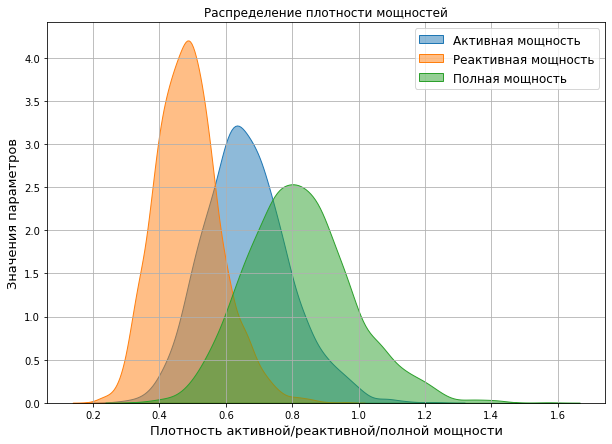

In [ ]:
plt.figure(figsize=(10,7))
plt.grid(True)
sns.kdeplot(data_arc_new_for_total_table['Активная мощность'],fill=True, alpha=0.5,
            legend=True, label='Активная мощность')
sns.kdeplot(data_arc_new_for_total_table['Реактивная мощность'],fill=True, alpha=0.5,
            legend=True, label='Реактивная мощность')
sns.kdeplot(data_arc_new_for_total_table['total_power'],fill=True, alpha=0.5,
            legend=True, label='Полная мощность')

plt.title('Распределение плотности мощностей');
plt.legend(fontsize=12);
plt.ylabel('Значения параметров',fontsize=13);
plt.xlabel("Плотность активной/реактивной/полной мощности", fontsize=13);
plt.show();

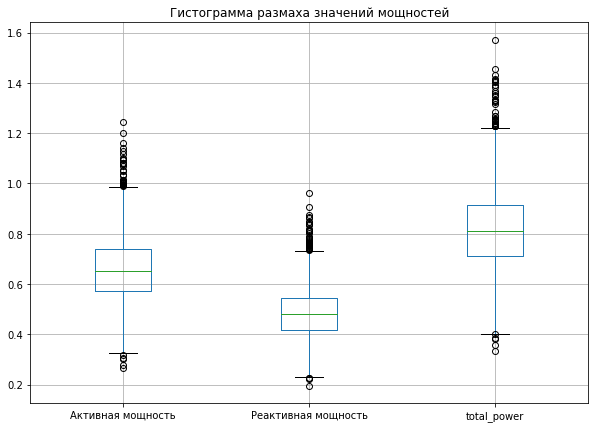

In [ ]:
plt.figure(figsize=(10,7))
plt.grid(True)
plt.title("Гистограмма размаха значений мощностей")
data_arc_new_for_total_table[['Активная мощность', 'Реактивная мощность',\
                              'total_power']].boxplot();


## Предобработка данных о подаче сыпучих материалов (объём и время)

Выяснили, что в данных много пропусков. Так как в таблицах определены примеси для каждой партии, значит эта примесь не использовалась в партии. Поэтому пропуски заполним нулями.
- data_bulk_new
- data_bulk_time_new

In [ ]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [ ]:
data_bulk_new = data_bulk_new.fillna(0)
data_bulk_time_new = data_bulk_time_new.fillna(0)

In [ ]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [ ]:
data_bulk_new.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

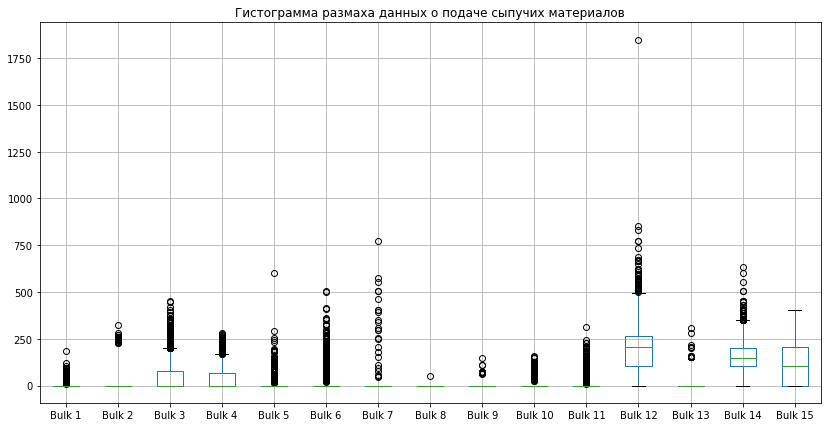

In [ ]:
plt.figure(figsize=(14, 7))
plt.title("Гистограмма размаха данных о подаче сыпучих материалов")
data_bulk_new.loc[:, data_bulk_new.columns != 'key'].boxplot();

bulk12 - какой-то выброс. Такие выбросы удалим на этапе обучения из тренировочной выборки.

In [ ]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## Предобработка данных о продувке сплава газом
data_gas_new

In [ ]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


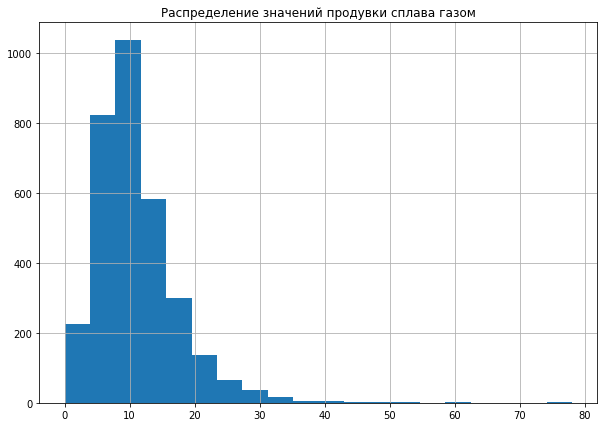

In [ ]:
plt.title('Распределение значений продувки сплава газом')
data_gas_new['Газ 1'].hist(figsize=(10, 7), bins=20);

## Предобработка данных  по измерению температуры

Удаляем строки, где значения температуры ниже 1500. Сформируем новую таблицу из даннной, оставив две температуры - начальную и конечную. Начальная температура будет являтся признаком, конечная - таргетом (целевым признаком).
Проверяем на наличие пропусков еще раз. Строим графики.

Есть записи, содержащие только одно время для партии, это не подходит для описанного технологического процесса, их удалим.

- data_temp_new

In [ ]:
data_temp_new.head(20)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


In [ ]:
data_temp_new = data_temp_new[data_temp_new['Температура'] >= 1500]

In [ ]:
data_temp_new.describe()

,key,Температура
count,14660.000000,14660.000000
mean,1325.369236,1590.852729
std,787.407873,19.143141
min,1.000000,1515.000000
25%,654.000000,1580.000000
50%,1314.000000,1590.000000
75%,1962.250000,1599.000000
max,3241.000000,1705.000000


In [ ]:
data_temp_new.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [ ]:
count_one_t = data_temp_new.groupby(by = 'key', as_index=False).count()
one = count_one_t[count_one_t['Время замера']== 1]['key'].tolist()
data_temp_new = data_temp_new.query('key not in @one')
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [ ]:
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


In [ ]:
data_temp_new_total_table = data_temp_new.groupby(by ='key').agg(['first', 'last']).reset_index()
data_temp_new_total_table.columns = data_temp_new_total_table.columns.droplevel()
data_temp_new_total_table.columns = ['key', 'Время замера 1', 'Время замера 2','t_start','t_end']
data_temp_new_total_table = data_temp_new_total_table[['key','t_start','t_end']]
data_temp_new_total_table

,key,t_start,t_end
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


## Предобработка данных о проволочных материалах (объём время)

Пропуски в обоих таблицах идентичны. Для обучения и тестирования модели потребуется только таблица, содержащая данные о проволочных материалах (объём), а данные с временем - не нужны, их не будем включать.

Пропуски говорят о том, что проволочные материалы не добавлялись в партию. Поэтому заменим пропуски нулями.
- data_wire_new
- data_wire_time_new

In [ ]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_wire_new = data_wire_new.fillna(0)

In [ ]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


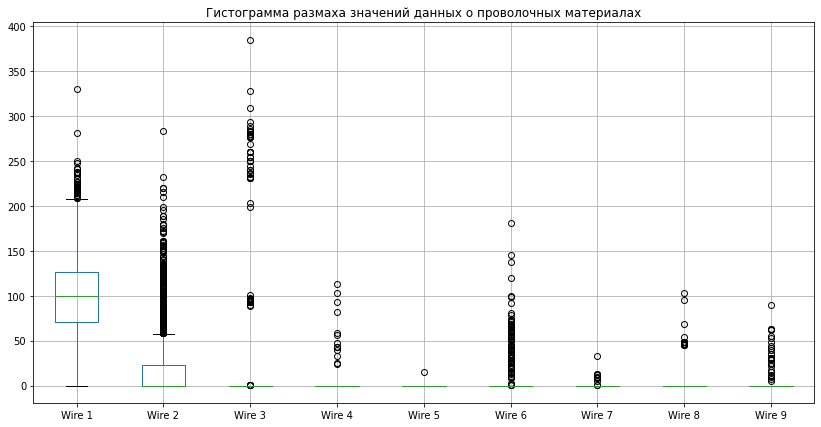

In [ ]:
plt.figure(figsize=(14, 7))
plt.title("Гистограмма размаха значений данных о проволочных материалах")
data_wire_new.loc[:, data_wire_new.columns != 'key'].boxplot();

Объединим данные из разных таблиц в одну сводную.

In [ ]:
data_total = (data_temp_new_total_table.merge(data_arc_new_for_total_table, how='inner', on = 'key').\
              merge(data_wire_new, how='inner', on = 'key').\
        merge(data_bulk_new, how='inner', on = 'key').\
        merge(data_gas_new, how='inner', on = 'key').\
             merge(df_arc_count,how='inner', on = 'key'))

data_total.head()

,key,t_start,t_end,Активная мощность,Реактивная мощность,lenght_t,total_power,Wire 1,Wire 2,Wire 3,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,iter_t
0,1,1571.0,1613.0,0.607346,0.428564,219.60,0.743328,60.059998,0.00000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,5
1,2,1581.0,1602.0,0.534852,0.363339,202.75,0.646593,96.052315,0.00000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,4
2,3,1596.0,1599.0,0.812728,0.587491,131.00,1.002833,91.160157,0.00000,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,5
3,4,1601.0,1625.0,0.676622,0.514248,185.25,0.849864,89.063515,0.00000,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,4
4,5,1576.0,1602.0,0.563238,0.421998,217.25,0.703789,89.238236,9.11456,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,4


In [ ]:
data_total['Wire 5'].sum()

0.0

Везде нули, удалим эту строку.

In [ ]:
data_total = data_total.drop('Wire 5', axis=1)

In [ ]:
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   key                  2329 non-null   int64  
 1   t_start              2329 non-null   float64
 2   t_end                2329 non-null   float64
 3   Активная мощность    2329 non-null   float64
 4   Реактивная мощность  2329 non-null   float64
 5   lenght_t             2329 non-null   float64
 6   total_power          2329 non-null   float64
 7   Wire 1               2329 non-null   float64
 8   Wire 2               2329 non-null   float64
 9   Wire 3               2329 non-null   float64
 10  Wire 4               2329 non-null   float64
 11  Wire 6               2329 non-null   float64
 12  Wire 7               2329 non-null   float64
 13  Wire 8               2329 non-null   float64
 14  Wire 9               2329 non-null   float64
 15  Bulk 1               2329 non-null   f

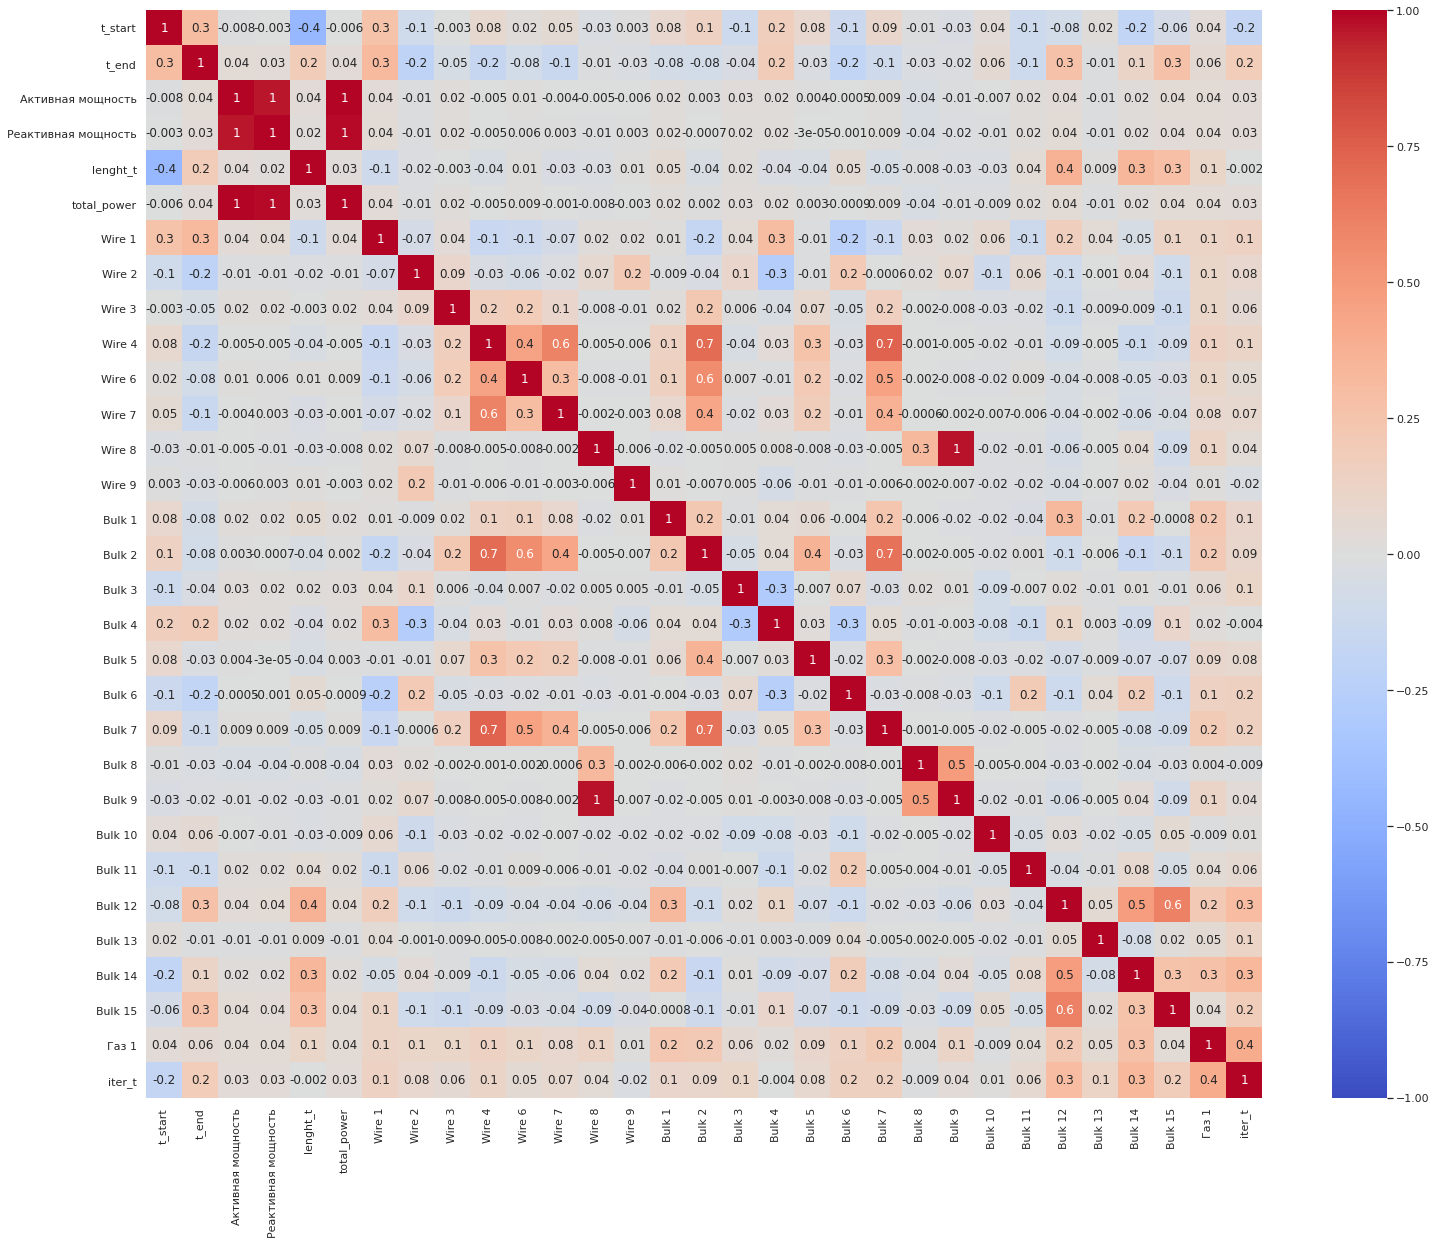

In [ ]:
data_cor =data_total.drop('key', axis=1)
sns.set(rc = {'figure.figsize':(25,20)})
sns.heatmap(data_cor.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm');

Наблюдается коллинеарность некоторых признаков, корреляциz dsit 0.9.
    
Такая зависимость отслеживается между признаками:<br/>
    - Wire_8 и Bulk_9<br/>
    - total_power и Активная и Реактивная мощность<br/>
Удалим следующие признаки, а именно: Wire_8, Активная и Реактивная мощность, total_power.
    Мощность показала себя как незначимый признак.
   

In [ ]:
data_cor.corr()

,t_start,t_end,Активная мощность,Реактивная мощность,lenght_t,total_power,Wire 1,Wire 2,Wire 3,Wire 4,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,iter_t
t_start,1.000000,0.301320,-0.008459,-0.003037,-0.437769,-0.006407,0.262598,-0.100733,-0.003485,0.076022,...,-0.011748,-0.033421,0.035584,-0.110481,-0.080115,0.020167,-0.181076,-0.063041,0.036047,-0.178086
t_end,0.301320,1.000000,0.040216,0.032770,0.194136,0.037749,0.317575,-0.206672,-0.047537,-0.159719,...,-0.026587,-0.016075,0.061350,-0.114753,0.267424,-0.010920,0.114617,0.266414,0.059160,0.181146
Активная мощность,-0.008459,0.040216,1.000000,0.965341,0.035116,0.995468,0.035735,-0.014680,0.019423,-0.005335,...,-0.041619,-0.010815,-0.007138,0.017616,0.038983,-0.013762,0.021415,0.040583,0.040255,0.033989
Реактивная мощность,-0.003037,0.032770,0.965341,1.000000,0.022936,0.985778,0.042879,-0.014663,0.020680,-0.004918,...,-0.040867,-0.017679,-0.010722,0.015797,0.042561,-0.013136,0.016833,0.038408,0.041630,0.032288
lenght_t,-0.437769,0.194136,0.035116,0.022936,1.000000,0.030910,-0.105494,-0.018378,-0.003457,-0.044419,...,-0.007834,-0.027756,-0.027549,0.041011,0.371249,0.008946,0.337428,0.281319,0.101987,-0.001533
total_power,-0.006407,0.037749,0.995468,0.985778,0.030910,1.000000,0.038560,-0.014848,0.019958,-0.005216,...,-0.041700,-0.013462,-0.008568,0.017072,0.040391,-0.013707,0.019696,0.039926,0.040870,0.033044
Wire 1,0.262598,0.317575,0.035735,0.042879,-0.105494,0.038560,1.000000,-0.068301,0.038075,-0.142005,...,0.034650,0.022596,0.062713,-0.117755,0.170167,0.039439,-0.053835,0.118437,0.117313,0.138280
Wire 2,-0.100733,-0.206672,-0.014680,-0.014663,-0.018378,-0.014848,-0.068301,1.000000,0.094073,-0.033758,...,0.018912,0.066733,-0.103758,0.062067,-0.098263,-0.001390,0.036309,-0.096415,0.104248,0.078237
Wire 3,-0.003485,-0.047537,0.019423,0.020680,-0.003457,0.019958,0.038075,0.094073,1.000000,0.169810,...,-0.002400,-0.008282,-0.027977,-0.021829,-0.120469,-0.008685,-0.008859,-0.118076,0.103382,0.055277
Wire 4,0.076022,-0.159719,-0.005335,-0.004918,-0.044419,-0.005216,-0.142005,-0.033758,0.169810,1.000000,...,-0.001336,-0.004609,-0.015571,-0.012153,-0.085535,-0.004833,-0.121828,-0.091352,0.145413,0.113648


In [ ]:
data_total.head()

,key,t_start,t_end,Активная мощность,Реактивная мощность,lenght_t,total_power,Wire 1,Wire 2,Wire 3,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,iter_t
0,1,1571.0,1613.0,0.607346,0.428564,219.60,0.743328,60.059998,0.00000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,5
1,2,1581.0,1602.0,0.534852,0.363339,202.75,0.646593,96.052315,0.00000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,4
2,3,1596.0,1599.0,0.812728,0.587491,131.00,1.002833,91.160157,0.00000,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,5
3,4,1601.0,1625.0,0.676622,0.514248,185.25,0.849864,89.063515,0.00000,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,4
4,5,1576.0,1602.0,0.563238,0.421998,217.25,0.703789,89.238236,9.11456,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,4


In [ ]:
data_total.describe()

,key,t_start,t_end,Активная мощность,Реактивная мощность,lenght_t,total_power,Wire 1,Wire 2,Wire 3,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,iter_t
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1587.386003,1593.365393,0.664095,0.488897,172.030434,0.824894,102.443601,17.609859,3.234916,...,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769,11.375600,4.695148
std,714.762400,23.619841,11.200915,0.128350,0.097947,43.741870,0.160188,43.539993,33.624771,27.942871,...,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443,6.392041,1.606948
min,1.000000,1519.000000,1541.000000,0.267676,0.196228,57.000000,0.331897,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1.000000
25%,630.000000,1571.000000,1587.000000,0.576249,0.420051,141.000000,0.713724,73.207679,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,4.000000
50%,1255.000000,1587.000000,1593.000000,0.655642,0.484690,169.500000,0.817669,101.119201,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,5.000000
75%,1868.000000,1603.000000,1598.000000,0.741566,0.546490,198.750000,0.920467,128.091599,23.102560,0.000000,...,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000,14.216688,6.000000
max,2499.000000,1660.000000,1653.000000,1.243889,0.960763,378.000000,1.571727,330.314424,282.780152,385.008668,...,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,16.000000


# Обучение модели

Целевой признак - последняя температура, которая храниться в столбце t_end. Признак "key" удаляем из таблицы как несущественный. Разделим данные на выборки.

In [ ]:
 data_total.head(10)

,key,t_start,t_end,Активная мощность,Реактивная мощность,lenght_t,total_power,Wire 1,Wire 2,Wire 3,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,iter_t
0,1,1571.0,1613.0,0.607346,0.428564,219.60,0.743328,60.059998,0.000000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,5
1,2,1581.0,1602.0,0.534852,0.363339,202.75,0.646593,96.052315,0.000000,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,4
2,3,1596.0,1599.0,0.812728,0.587491,131.00,1.002833,91.160157,0.000000,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,5
3,4,1601.0,1625.0,0.676622,0.514248,185.25,0.849864,89.063515,0.000000,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,4
4,5,1576.0,1602.0,0.563238,0.421998,217.25,0.703789,89.238236,9.114560,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,4
5,6,1543.0,1596.0,0.681318,0.470328,238.00,0.827891,99.109917,9.114560,0.0,...,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392,4
6,7,1586.0,1599.0,0.656719,0.490105,168.25,0.819441,98.061600,0.000000,0.0,...,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267,4
7,8,1577.0,1598.0,0.669740,0.524238,228.25,0.850515,155.282394,0.000000,0.0,...,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553,4
8,9,1587.0,1592.0,0.704164,0.505473,125.00,0.866804,113.393279,9.143681,0.0,...,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623,5
9,10,1574.0,1593.0,0.519796,0.359157,137.50,0.631808,81.244796,12.376000,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,102.0,204.0,6.529891,6


In [ ]:
targets = data_total['t_end']
features = data_total.drop(['t_end','key','Реактивная мощность','Активная мощность','Wire 8','total_power'], axis=1)

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, targets,
                                                                            random_state=280823, test_size=0.25)

In [ ]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((1746, 26), (1746,), (583, 26), (583,))

# Модель "Случайный лес"

Подберем наилучшие параметры на кроссвалидации. Обучим модель. Посчитаем время.

In [ ]:
%%time
model_RFR = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=280823))
params_RFR = {"randomforestregressor__n_estimators": range(5,100,10),
             "randomforestregressor__max_depth": range(1, 6)}
grid_RFR = GridSearchCV(model_RFR,param_grid = params_RFR,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        verbose=10)
grid_RFR.fit(features_train, target_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 1/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5; total time=   0.0s
[CV 2/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 2/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5; total time=   0.0s
[CV 3/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 3/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5; total time=   0.0s
[CV 4/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 4/5; 1/50] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5; total time=   0.0s
[CV 5/5; 1/50] START randomforestregressor__max_depth=1, randomforestregressor__n_estimators=5
[CV 5/5; 1/

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=280823))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(1, 6),
                         'randomforestregressor__n_estimators': range(5, 100, 10)},
             scoring='neg_mean_absolute_error', verbose=10)

In [ ]:
abs(grid_RFR.best_score_), grid_RFR.best_estimator_

(6.840044313498835,
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestregressor',
                  RandomForestRegressor(max_depth=5, n_estimators=45,
                                        random_state=280823))]))

# Модель CatBoost

In [ ]:
%%time
model_CtB = CatBoostRegressor(random_state=280823)
parameters = {'depth' : [6,8,10,20],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid_CtB = GridSearchCV(estimator=model_CtB,
                        param_grid = parameters,
                        scoring='neg_mean_absolute_error',
                        cv = 3,
                        n_jobs=-1)
grid_CtB.fit(features_train, target_train)


0:	learn: 11.0838402	total: 51.7ms	remaining: 1.5s
1:	learn: 11.0687195	total: 55.6ms	remaining: 779ms
2:	learn: 11.0430701	total: 59.8ms	remaining: 538ms
3:	learn: 11.0166203	total: 63.5ms	remaining: 413ms
4:	learn: 10.9914839	total: 67.5ms	remaining: 337ms
5:	learn: 10.9657286	total: 71.1ms	remaining: 284ms
6:	learn: 10.9455044	total: 74ms	remaining: 243ms
7:	learn: 10.9171801	total: 77.9ms	remaining: 214ms
8:	learn: 10.8985259	total: 81.4ms	remaining: 190ms
9:	learn: 10.8741023	total: 85.2ms	remaining: 170ms
10:	learn: 10.8515041	total: 88.9ms	remaining: 154ms
11:	learn: 10.8301410	total: 92.3ms	remaining: 138ms
12:	learn: 10.8115024	total: 94.5ms	remaining: 124ms
13:	learn: 10.7879789	total: 96.7ms	remaining: 110ms
14:	learn: 10.7612766	total: 99ms	remaining: 99ms
15:	learn: 10.7419478	total: 102ms	remaining: 89.2ms
16:	learn: 10.7224918	total: 105ms	remaining: 80.3ms
17:	learn: 10.6988691	total: 107ms	remaining: 71.6ms
18:	learn: 10.6780073	total: 111ms	remaining: 64ms
19:	learn: 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 10.9015375	total: 2.97ms	remaining: 294ms
1:	learn: 10.7063041	total: 5.66ms	remaining: 278ms
2:	learn: 10.5192484	total: 8.31ms	remaining: 269ms
3:	learn: 10.2877359	total: 11ms	remaining: 264ms
4:	learn: 10.0846037	total: 13.7ms	remaining: 260ms
5:	learn: 9.9547254	total: 16.3ms	remaining: 255ms
6:	learn: 9.8039157	total: 18.8ms	remaining: 250ms
7:	learn: 9.6402566	total: 21.4ms	remaining: 246ms
8:	learn: 9.5470843	total: 24ms	remaining: 243ms
9:	learn: 9.4607851	total: 26.6ms	remaining: 240ms
10:	learn: 9.3550297	total: 29.1ms	remaining: 235ms
11:	learn: 9.2695225	total: 31.6ms	remaining: 232ms
12:	learn: 9.1694053	total: 34.4ms	remaining: 230ms
13:	learn: 9.0581212	total: 37.6ms	remaining: 231ms
14:	learn: 8.9825187	total: 40.1ms	remaining: 227ms
15:	learn: 8.8932431	total: 43.3ms	remaining: 227ms
16:	learn: 8.8150580	total: 45.9ms	remaining: 224ms
17:	learn: 8.7478932	total: 48.3ms	remaining: 220ms
18:	learn: 8.7040737	total: 52.6ms	remaining: 224ms
19:	learn: 8.6240990	

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f09e98f74f0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10, 20], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_absolute_error')

In [ ]:
abs(grid_CtB.best_score_)
grid_CtB.best_estimator_.feature_importances_

array([2.35988575e+01, 1.86399629e+01, 8.15927784e+00, 4.22845817e+00,
       5.14062986e-01, 9.19050525e-01, 2.25049277e-01, 1.27993437e-02,
       6.59875203e-03, 3.12014595e+00, 1.29062419e-01, 7.87538983e-01,
       1.55817881e+00, 2.02263877e-01, 5.55085025e+00, 1.30001495e+00,
       0.00000000e+00, 0.00000000e+00, 1.37700705e-01, 3.81560252e-01,
       3.22969572e+00, 9.47872721e-02, 3.00581541e+00, 6.18897046e+00,
       3.12105773e+00, 1.48882399e+01])

In [ ]:
predict_Ctb = grid_CtB.predict(features_test)
mae = mean_absolute_error(target_test, predict_Ctb)
mae

6.1015240110286255

Сравним полученную метрику с константной моделью по среднему.

In [ ]:
dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(features_train, target_train)
predict = dummy_regr.predict(features_test)

print('Метрика MAE константной моделью')
print('MAE: {:.7f}'.format(mean_absolute_error(target_test, predict)))

Метрика MAE константной моделью
MAE: 8.2863256


# Исследуем значимость признаков в выбранной модели

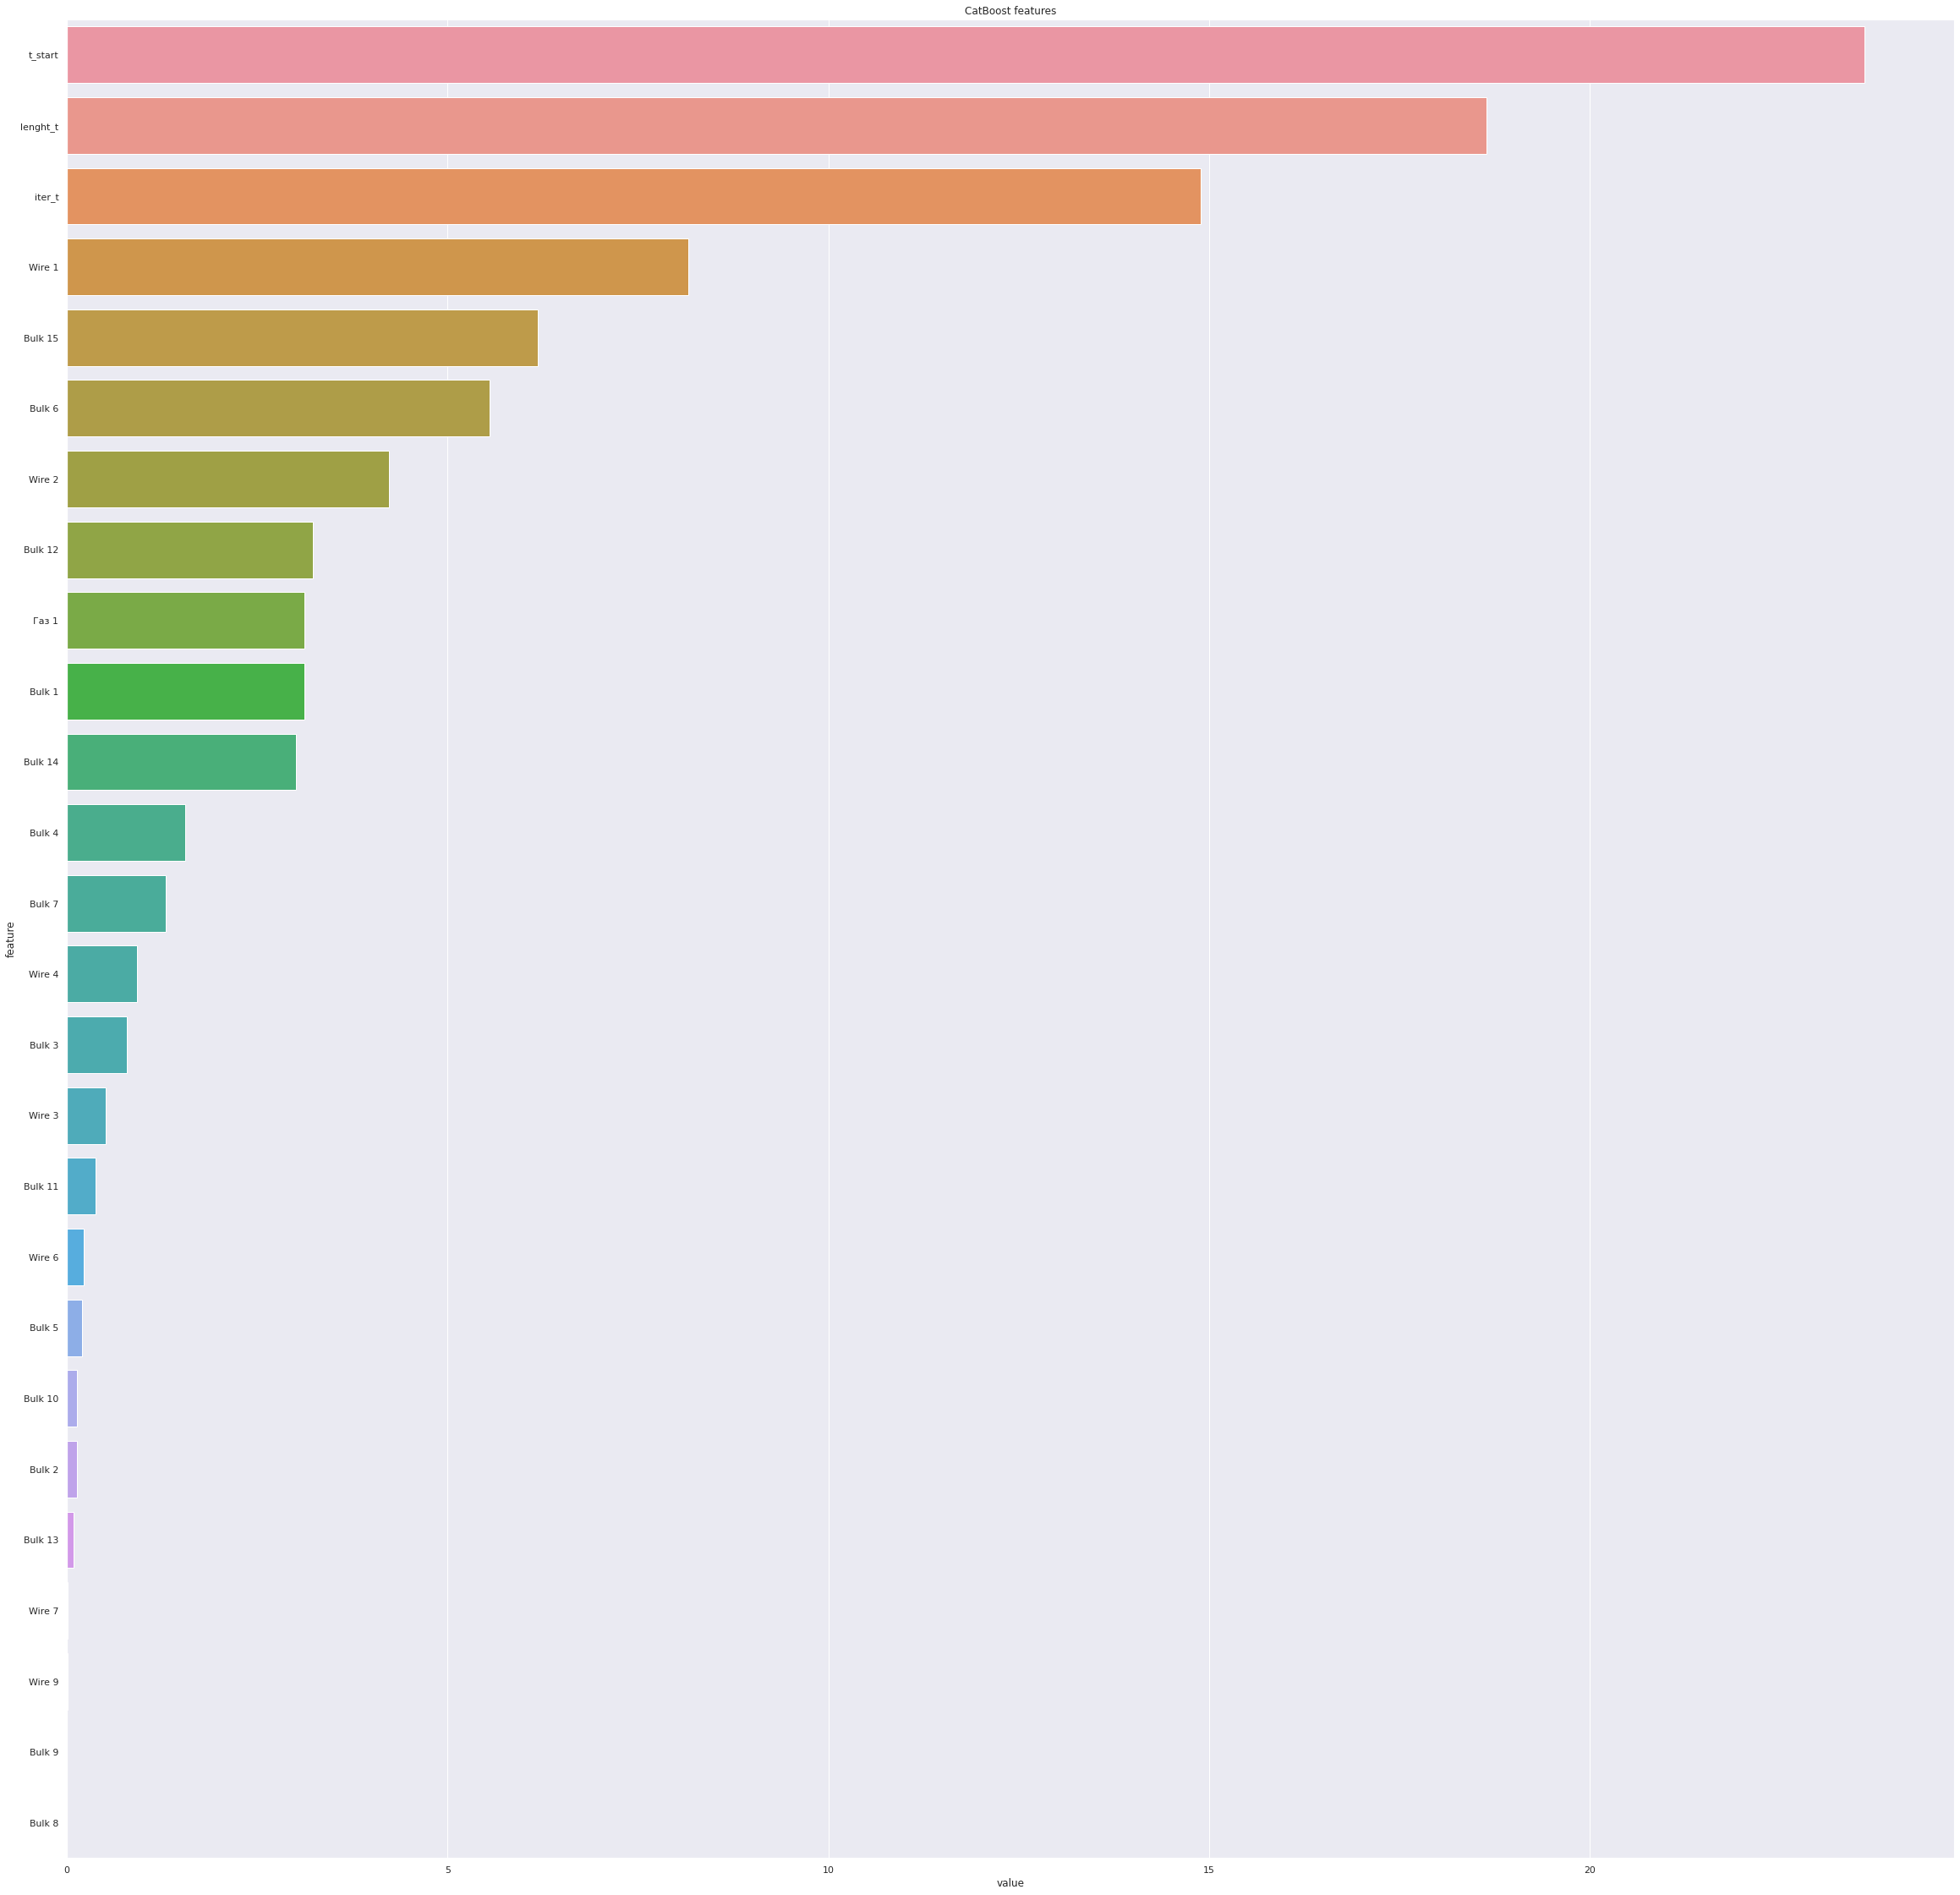

In [ ]:
feature_importance = pd.DataFrame({'value':grid_CtB.best_estimator_.feature_importances_,'feature':features_test.columns})
plt.figure(figsize=(40, 40))
sns.barplot(x="value", y="feature", data=feature_importance.sort_values(by="value", ascending=False))
plt.title('CatBoost features')
plt.show()

# Выводы по второму этапу

В ходе работ над вторым этапом решены следующие задачи:

- Удалили аномалии, обработали пропуски.
- Рассчитали дополнительные признаки: полную мощность, длительность нагревания, количество итераций нагрева.
- После обработки данных таблицы объединены в общую. Добавлены дополнительные признаки: полная мощность, длительность нагревания, количество итераций нагрева.
- Построена тепловая карта и корреляционная таблица, которые позволяют оценить степень влияния признаков друг на друга.
- При подготовке модели к обучению сделано умозаключение, что такие признаки как мощность являются несущественными и их можно удалить.
- Все выбросы решено оставить в модели, так как в технологическом процессе допускается наличие подобных критических значений.
- Данные разделены на обучающую и тестовую выборки в соотношении 3:1.
- Для обучения рассмотрены две модели: «Случайный лес» и «CatBoost». На кроссвалидации подораны наилучшие параметры, обе модели работают достаточно быстро и обе показывают приемлемое значение метрики. Однако лучшее значение дает CatBoost. Ее и используем для тестирования.
- На обучающей выборке метрика равна 6.265569924723067, на тестовой: 6.206881764918606. Результат удовлетворительный.
- Выполнено сравнение с константной моделью Значение на константе гораздо хуже.

- Выполнена проверка значимости признаков. Признаки проранжированы по значимости и выведеныы в таблице. Начальная температура является самым значимым признаком. Следующие по приоритетности - два дополнительных признака: длительности нагревания сплава  количество итераций нагрева, затем следуют параметры wire и bulk.

